# Loja Vrinda #




### Dados baixado via API Kaggle 

https://www.kaggle.com/datasets/anshika2301/vrinda-store-data-analysis


  ## Sobre o conjunto de dados
  
> Os dados na loja apresentam informações sobre as atividades e métricas das empresas de varejo, como tráfego de visitantes (contagem de pessoas), comportamento do cliente, dados de vendas, padrões de compra dos clientes e estoques de produtos.

## 1- Baixando as Bibliotecas 

In [255]:
# importando as Bibliotecas
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import pymssql as sql
import warnings
warnings.filterwarnings("ignore")
import pyodbc
import sqlalchemy as sa 
from google.cloud import bigquery
from google.oauth2 import service_account
import openpyxl
from scipy.stats import skew

## 2 - Configurando as Credenciais  Kaggle

In [2]:
# Configurar as credenciais
os.environ['KAGGLE_USERNAME'] = "r........................"
os.environ['KAGGLE_KEY'] = "eb..............."


In [136]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Configurar a API do Kaggle
api = KaggleApi()
api.authenticate()

# Nome do dono do conjunto de dados e nome do conjunto de dados
owner = 'anshika2301'
dataset_name = 'vrinda-store-data-analysis'

# Baixar o conjunto de dados
api.dataset_download_files(f"{owner}/{dataset_name}", unzip=True)


## Acessando o kaggle extraindo os dados e carregando no Amazon S3(camada row)

In [166]:
# Configurações do AWS
AWS_ACCESS_KEY = "AKIA5U........"
AWS_SECRET_KEY = "XjaHyb8eU.........."
AWS_REGION = "us-east-2"

# Configurações do Kaggle
dataset_slug = "anshika2301/vrinda-store-data-analysis"
output_folder = "C:/Users/ROBERTO/MeusDocumentos"


# Configurações do Amazon S3 
bucket_name = "datalakelojavrinda"
s3_folder = "staging/Camada_row"

def download_from_kaggle(dataset_slug, output_folder):
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    kaggle.api.dataset_download_files(dataset_slug, path=output_folder, unzip=True, force=True, quiet=False)

def upload_to_s3(local_file, bucket, s3_folder):
    s3 = boto3.client("s3", aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY, region_name=AWS_REGION)

    # Lista todos os arquivos no diretório local
    local_files = glob.glob(os.path.join(local_file, "*"))

    # Loop para upload de cada arquivo
    for file in local_files:
        try:
            # Obtém o nome do arquivo a partir do caminho
            file_name = os.path.basename(file)
            # Upload do arquivo para o Amazon S3
            s3.upload_file(file, bucket, f"{s3_folder}/{file_name}")
            print(f"Upload bem-sucedido para o Amazon S3: {file_name}")
        except FileNotFoundError:
            print(f"Arquivo local não encontrado: {file}")
        except NoCredentialsError:
            print("Credenciais do AWS não disponíveis ou incorretas.")

# Download do dataset do Kaggle
download_from_kaggle(dataset_slug, output_folder)

# Upload de todos os arquivos para o Amazon S3
upload_to_s3(output_folder, bucket_name, s3_folder)

100%|█████████████████████████████████████████████████████████████████████████████| 8.71M/8.71M [00:01<00:00, 8.16MB/s]



Upload bem-sucedido para o Amazon S3: Store Data Analysis.xlsx
Upload bem-sucedido para o Amazon S3: Store Data.xlsx


##  Acessando o conteúdo do s3

In [167]:
# acessando o conteúdo do s3

# Configurações do AWS
AWS_ACCESS_KEY = ".............."
AWS_SECRET_KEY = "XjaHyb8eUyFt......."
AWS_REGION = "us-east-2"

# Configurações do Amazon S3
bucket_name = "datalakelojavrinda"
s3_folder = "staging/"

# Configuração do cliente S3
s3 = boto3.client("s3", aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY, region_name=AWS_REGION)

# Lista objetos no bucket
response = s3.list_objects(Bucket=bucket_name, Prefix=s3_folder)

# Exibe os nomes dos objetos encontrados
for obj in response.get('Contents', []):
    print(obj['Key'])


staging/
staging/Camada_row/Store Data Analysis.xlsx
staging/Camada_row/Store Data.xlsx


## Acessando e extraindo o arquivo "Data Store" no S3 


In [177]:
# Acessando e extraindo o arquivo" Data Store" no S3 


# Configurações do AWS
AWS_ACCESS_KEY = "AKIA5......"
AWS_SECRET_KEY = "XjaHyb8eUyFt+hq......"
AWS_REGION = "us-east-2"



# Configurações do Amazon S3
bucket_name = "datalakelojavrinda"
s3_folder = "staging/Camada_row"
s3_file_name = "Store Data.xlsx"

# Configuração do cliente S3
s3 = boto3.client("s3", aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY, region_name=AWS_REGION)

# Download do arquivo do S3
local_file_path = "C:/Users/ROBERTO/Store Data.xlsx"
s3.download_file(bucket_name, f"{s3_folder}/{s3_file_name}", local_file_path)



# Carrega o arquivo para um DataFrame (pandas)
df_store_data = pd.read_excel(local_file_path)





#  Análise Exploratória 

## 1. Visualizando a base de dados

In [178]:
# Exibe o DataFrame

df_store_data.head()



,index,Order ID,Cust ID,Gender,Age,Age Group,Date,Month,Status,Channel,...,Category,Size,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B
0,1,171-1029312-3038738,1029312,Women,44,Adult,2022-12-04,Dec,Delivered,Myntra,...,kurta,XXL,1,INR,376,MOHALI,PUNJAB,140301,IN,False
1,2,405-2183842-2225946,2183842,Women,29,Teenager,2022-12-04,Dec,Delivered,Ajio,...,Set,L,1,INR,1449,GURUGRAM,HARYANA,122002,IN,False
2,3,171-1641533-8921966,1641533,Women,67,Senior,2022-12-04,Dec,Delivered,Myntra,...,Set,S,1,INR,453,KOLKATA,WEST BENGAL,700029,IN,False
3,4,404-7490807-6300351,7490807,Women,20,Teenager,2022-12-04,Dec,Delivered,Amazon,...,Set,M,1,INR,729,THANJAVUR,TAMIL NADU,613007,IN,False
4,5,403-9293516-4577154,9293516,Women,62,Senior,2022-12-04,Dec,Delivered,Myntra,...,kurta,XXL,1,INR,544,GURUGRAM,HARYANA,122001,IN,False


In [179]:
df_store_data.shape

(31047, 21)

In [8]:
df_store_data.dtypes

index                        int64
Order ID                    object
Cust ID                      int64
Gender                      object
Age                          int64
Age Group                   object
Date                datetime64[ns]
Month                       object
Status                      object
Channel                     object
SKU                         object
Category                    object
Size                        object
Qty                          int64
currency                    object
Amount                       int64
ship-city                   object
ship-state                  object
ship-postal-code             int64
ship-country                object
B2B                           bool
dtype: object

In [9]:
df_store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31047 entries, 0 to 31046
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             31047 non-null  int64         
 1   Order ID          31047 non-null  object        
 2   Cust ID           31047 non-null  int64         
 3   Gender            31047 non-null  object        
 4   Age               31047 non-null  int64         
 5   Age Group         31047 non-null  object        
 6   Date              31047 non-null  datetime64[ns]
 7   Month             31047 non-null  object        
 8   Status            31047 non-null  object        
 9   Channel           31047 non-null  object        
 10  SKU               31047 non-null  object        
 11  Category          31047 non-null  object        
 12  Size              31047 non-null  object        
 13  Qty               31047 non-null  int64         
 14  currency          3104

## Renomeando as colunas para Português

In [181]:
# Dicionário de mapeamento para renomear as colunas

novo_nome_colunas = {
    'Order ID': 'ID do Pedido',
    'Cust ID': 'ID do Cliente',
    'Gender': 'Gênero',
    'Age': 'Idade',
    'Age Group': 'Grupo Etário',
    'Date': 'Data',
    'Month': 'Mês',
    'Status': 'Status',
    'Channel ': 'Canal',
    'SKU': 'SKU',
    'Category': 'Categoria',
    'Size': 'Tamanho',
    'Qty': 'Quantidade',
    'currency': 'Moeda',
    'Amount': 'Valor',
    'ship-city': 'Cidade de Entrega',
    'ship-state': 'Estado de Entrega',
    'ship-postal-code': 'Código Postal de Entrega',
    'ship-country': 'País de Entrega',
    'B2B': 'B2B',
    
}

# Renomeia as colunas do DataFrame
df_store_data = df_store_data.rename(columns=novo_nome_colunas)

# Verifica se as colunas foram renomeadas corretamente
df_store_data.head()

,index,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,...,Categoria,Tamanho,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B
0,1,171-1029312-3038738,1029312,Women,44,Adult,2022-12-04,Dec,Delivered,Myntra,...,kurta,XXL,1,INR,376,MOHALI,PUNJAB,140301,IN,False
1,2,405-2183842-2225946,2183842,Women,29,Teenager,2022-12-04,Dec,Delivered,Ajio,...,Set,L,1,INR,1449,GURUGRAM,HARYANA,122002,IN,False
2,3,171-1641533-8921966,1641533,Women,67,Senior,2022-12-04,Dec,Delivered,Myntra,...,Set,S,1,INR,453,KOLKATA,WEST BENGAL,700029,IN,False
3,4,404-7490807-6300351,7490807,Women,20,Teenager,2022-12-04,Dec,Delivered,Amazon,...,Set,M,1,INR,729,THANJAVUR,TAMIL NADU,613007,IN,False
4,5,403-9293516-4577154,9293516,Women,62,Senior,2022-12-04,Dec,Delivered,Myntra,...,kurta,XXL,1,INR,544,GURUGRAM,HARYANA,122001,IN,False


In [182]:
df_store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31047 entries, 0 to 31046
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   index                     31047 non-null  int64         
 1   ID do Pedido              31047 non-null  object        
 2   ID do Cliente             31047 non-null  int64         
 3   Gênero                    31047 non-null  object        
 4   Idade                     31047 non-null  int64         
 5   Grupo Etário              31047 non-null  object        
 6   Data                      31047 non-null  datetime64[ns]
 7   Mês                       31047 non-null  object        
 8   Status                    31047 non-null  object        
 9   Canal                     31047 non-null  object        
 10  SKU                       31047 non-null  object        
 11  Categoria                 31047 non-null  object        
 12  Tamanho           

 ## Renomeando os registros da colunas : Gênero,Status e Grupo Etário

In [184]:


# Mapeamentos de substituição
mapeamento_genero = {'Men': 'Masculino', 'Women': 'Feminino', }
mapeamento_status = {'Delivered': 'Entregue', 'Returned': 'Devolvido', 'Cancelled': 'Cancelado', 'Refunded': 'Reembolsado'}
mapeamento_grupo_etario = {'Adult': 'Adulto', 'Teenager': 'Adolescente', 'Senior': 'Mais Antigo'}

# Renomeia os registros nas colunas correspondentes
df_store_data['Gênero'] = df_store_data['Gênero'].replace(mapeamento_genero)
df_store_data['Status'] = df_store_data['Status'].replace(mapeamento_status)
df_store_data['Grupo Etário'] = df_store_data['Grupo Etário'].replace(mapeamento_grupo_etario)

# Resultado final
df_store_data.head()


,index,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,...,Categoria,Tamanho,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B
0,1,171-1029312-3038738,1029312,Feminino,44,Adulto,2022-12-04,Dec,Entregue,Myntra,...,kurta,XXL,1,INR,376,MOHALI,PUNJAB,140301,IN,False
1,2,405-2183842-2225946,2183842,Feminino,29,Adolescente,2022-12-04,Dec,Entregue,Ajio,...,Set,L,1,INR,1449,GURUGRAM,HARYANA,122002,IN,False
2,3,171-1641533-8921966,1641533,Feminino,67,Mais Antigo,2022-12-04,Dec,Entregue,Myntra,...,Set,S,1,INR,453,KOLKATA,WEST BENGAL,700029,IN,False
3,4,404-7490807-6300351,7490807,Feminino,20,Adolescente,2022-12-04,Dec,Entregue,Amazon,...,Set,M,1,INR,729,THANJAVUR,TAMIL NADU,613007,IN,False
4,5,403-9293516-4577154,9293516,Feminino,62,Mais Antigo,2022-12-04,Dec,Entregue,Myntra,...,kurta,XXL,1,INR,544,GURUGRAM,HARYANA,122001,IN,False


 ## Fazendo Engenharia de Atributos 
 
 ### Recategorização da variável Idade e gerando uma coluna de Faixa Etária

In [185]:
# Define os limites das faixas etárias
faixas_etarias = [0, 18, 30, 45, 60, 75, 100]

# Define os rótulos para as faixas etárias
rotulos_faixas = ['0-18', '19-30', '31-45', '46-60','61-75', '75+']

# Cria uma nova coluna 'Faixa Etária' usando pd.cut
df_store_data['Faixa Etária'] = pd.cut(df_store_data['Idade'], bins=faixas_etarias, labels=rotulos_faixas, right=False)

# Exibe o DataFrame resultante
df_store_data.head()

,index,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,...,Tamanho,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B,Faixa Etária
0,1,171-1029312-3038738,1029312,Feminino,44,Adulto,2022-12-04,Dec,Entregue,Myntra,...,XXL,1,INR,376,MOHALI,PUNJAB,140301,IN,False,31-45
1,2,405-2183842-2225946,2183842,Feminino,29,Adolescente,2022-12-04,Dec,Entregue,Ajio,...,L,1,INR,1449,GURUGRAM,HARYANA,122002,IN,False,19-30
2,3,171-1641533-8921966,1641533,Feminino,67,Mais Antigo,2022-12-04,Dec,Entregue,Myntra,...,S,1,INR,453,KOLKATA,WEST BENGAL,700029,IN,False,61-75
3,4,404-7490807-6300351,7490807,Feminino,20,Adolescente,2022-12-04,Dec,Entregue,Amazon,...,M,1,INR,729,THANJAVUR,TAMIL NADU,613007,IN,False,19-30
4,5,403-9293516-4577154,9293516,Feminino,62,Mais Antigo,2022-12-04,Dec,Entregue,Myntra,...,XXL,1,INR,544,GURUGRAM,HARYANA,122001,IN,False,61-75


## Adicionando  uma coluna Mês_número para ordenar os meses 

In [241]:
# Mapeando os meses para números
meses_numeros = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df_store_data['Mes_Numero'] = df_store_data.sort_values('Mes_Numero')['Mês'].map(meses_numeros)
df_store_data = df_store_data.sort_values('Mes_Numero')
df_store_data

,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,SKU,...,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B,Faixa Etária,Mes_Numero
31046,408-4694875-8249153,4694875,Masculino,36,Adulto,2022-01-06,Jan,Entregue,Flipkart,J0341-DR-XXXL,...,1,INR,791,WARANGAL,TELANGANA,506001,IN,False,31-45,1
10655,402-4825408-3491550,4825408,Masculino,49,Adulto,2022-01-04,Jan,Entregue,Meesho,J0011-LCD-M,...,1,INR,1695,KOLKATA,WEST BENGAL,700075,IN,False,46-60,1
10656,402-4003610-3161169,4003610,Feminino,26,Adolescente,2022-01-04,Jan,Entregue,Myntra,JNE3476-KR-XL,...,1,INR,363,NEW DELHI,DELHI,110017,IN,False,19-30,1
10657,408-2409103-9856336,2409103,Feminino,23,Adolescente,2022-01-04,Jan,Entregue,Flipkart,J0349-SET-M,...,1,INR,791,HYDERABAD,TELANGANA,500032,IN,False,19-30,1
10658,402-9068892-1041116,9068892,Masculino,75,Mais Antigo,2022-01-04,Jan,Entregue,Ajio,SET253-KR-NP-L,...,1,INR,737,HYDERABAD,TELANGANA,500020,IN,False,75+,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10910,402-3747697-3263557,3747697,Feminino,46,Adulto,2022-12-05,Dec,Entregue,Amazon,SET398-KR-PP-XXXL,...,1,INR,1129,NEW DELHI,DELHI,110027,IN,False,46-60,12
10911,171-7605234-2616357,7605234,Feminino,18,Adolescente,2022-12-05,Dec,Entregue,Flipkart,J0118-TP-M,...,1,INR,529,JAMMU,JAMMU & KASHMIR,180004,IN,False,19-30,12
10912,408-4804006-2777930,4804006,Feminino,37,Adulto,2022-12-05,Dec,Entregue,Myntra,JNE3645-TP-N-M,...,1,INR,432,BENGALURU,KARNATAKA,560076,IN,False,31-45,12
10938,402-3766529-0479569,3766529,Masculino,52,Mais Antigo,2022-12-05,Dec,Devolvido,Flipkart,JNE3797-KR-XXXL,...,1,INR,715,pune,MAHARASHTRA,411048,IN,False,46-60,12


 ## verificando valores únicos 

In [186]:
# Seleciona valores únicos da coluna 'Grupo Etário'

valores_unicos = df_store_data['Grupo Etário'].unique()
valores_unicos

array(['Adulto', 'Adolescente', 'Mais Antigo'], dtype=object)

In [187]:
# Seleciona valores únicos da coluna 'Mês'

valores_unicos = df_store_data['Mês'].unique()
valores_unicos

array(['Dec', 'Nov', 'Oct', 'Sep', 'Aug', 'Jul', 'Jun', 'May', 'Apr',
       'Mar', 'Feb', 'Jan'], dtype=object)

In [188]:
# Seleciona valores únicos da coluna 'Status'

valores_unicos = df_store_data['Status'].unique()
valores_unicos

array(['Entregue', 'Reembolsado', 'Cancelado', 'Devolvido'], dtype=object)

In [17]:
# Seleciona valores únicos da coluna 'Gênero'

valores_unicos = df_store_data['Gênero'].unique()
valores_unicos

array(['Feminino', 'Masculino'], dtype=object)

In [189]:
# Seleciona valores únicos da coluna 'Cidade de Entrega'

valores_unicos = df_store_data['Cidade de Entrega'].unique()
valores_unicos

array(['MOHALI', 'GURUGRAM', 'KOLKATA', ..., 'North 24 parganas', 'DIPHU',
       'VILE BHAGAD MIDC'], dtype=object)

## Vamos remover a coluna index

In [190]:
df_store_data.drop('index', axis=1, inplace=True)

In [191]:
df_store_data.head()

,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,SKU,...,Tamanho,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B,Faixa Etária
0,171-1029312-3038738,1029312,Feminino,44,Adulto,2022-12-04,Dec,Entregue,Myntra,JNE1233-BLUE-KR-031-XXL,...,XXL,1,INR,376,MOHALI,PUNJAB,140301,IN,False,31-45
1,405-2183842-2225946,2183842,Feminino,29,Adolescente,2022-12-04,Dec,Entregue,Ajio,SET414-KR-NP-L,...,L,1,INR,1449,GURUGRAM,HARYANA,122002,IN,False,19-30
2,171-1641533-8921966,1641533,Feminino,67,Mais Antigo,2022-12-04,Dec,Entregue,Myntra,SET261-KR-PP-S,...,S,1,INR,453,KOLKATA,WEST BENGAL,700029,IN,False,61-75
3,404-7490807-6300351,7490807,Feminino,20,Adolescente,2022-12-04,Dec,Entregue,Amazon,SET110-KR-PP-M,...,M,1,INR,729,THANJAVUR,TAMIL NADU,613007,IN,False,19-30
4,403-9293516-4577154,9293516,Feminino,62,Mais Antigo,2022-12-04,Dec,Entregue,Myntra,JNE2294-KR-A-XXL,...,XXL,1,INR,544,GURUGRAM,HARYANA,122001,IN,False,61-75


##  verificando Valores ausentes 

In [192]:
# Verificar valores ausentes em cada coluna
valores_ausentes = df_store_data.isnull().sum()

# Exibir a contagem de valores ausentes
print(valores_ausentes)

ID do Pedido                0
ID do Cliente               0
Gênero                      0
Idade                       0
Grupo Etário                0
Data                        0
Mês                         0
Status                      0
Canal                       0
SKU                         0
Categoria                   0
Tamanho                     0
Quantidade                  0
Moeda                       0
Valor                       0
Cidade de Entrega           0
Estado de Entrega           0
Código Postal de Entrega    0
País de Entrega             0
B2B                         0
Faixa Etária                0
dtype: int64


In [193]:
df_store_data['B2B'].value_counts()

False    30861
True       186
Name: B2B, dtype: int64

In [194]:
# Calcular a porcentagem de valores ausentes em cada coluna
porcentagem_ausentes = (df_store_data.isnull().sum() / len(df)) * 100

# Exibir a porcentagem de valores ausentes
print(porcentagem_ausentes)

ID do Pedido                0.0
ID do Cliente               0.0
Gênero                      0.0
Idade                       0.0
Grupo Etário                0.0
Data                        0.0
Mês                         0.0
Status                      0.0
Canal                       0.0
SKU                         0.0
Categoria                   0.0
Tamanho                     0.0
Quantidade                  0.0
Moeda                       0.0
Valor                       0.0
Cidade de Entrega           0.0
Estado de Entrega           0.0
Código Postal de Entrega    0.0
País de Entrega             0.0
B2B                         0.0
Faixa Etária                0.0
dtype: float64


In [195]:
df_store_data.describe()

,ID do Cliente,Idade,Quantidade,Valor,Código Postal de Entrega
count,3.104700e+04,31047.000000,31047.000000,31047.000000,31047.000000
mean,4.936824e+06,39.496570,1.006120,682.074822,460474.587206
std,2.900678e+06,15.117233,0.094088,268.582173,198116.733009
min,8.950000e+02,18.000000,1.000000,229.000000,110001.000000
25%,2.416471e+06,28.000000,1.000000,486.000000,313001.000000
50%,4.909885e+06,37.000000,1.000000,646.000000,500028.000000
75%,7.454182e+06,47.000000,1.000000,794.000000,600040.000000
max,9.999233e+06,78.000000,5.000000,3036.000000,855117.000000


##  Verificando  Outliers

In [242]:
from scipy import stats

# Calculando o z-score para todas as colunas numéricas
z_scores = stats.zscore(df_store_data.select_dtypes(include='number'))

# Definindo um threshold para identificar outliers (por exemplo, 3 desvios padrão)
threshold = 3
outliers = (z_scores > threshold) | (z_scores < -threshold)

# Exibindo a contagem de outliers por coluna
outliers_count = pd.DataFrame(outliers, columns=df_store_data.columns).sum()
print(outliers_count)

ID do Pedido                  0.0
ID do Cliente                 0.0
Gênero                        0.0
Idade                         0.0
Grupo Etário                  0.0
Data                          0.0
Mês                           0.0
Status                        0.0
Canal                         0.0
SKU                           0.0
Categoria                     0.0
Tamanho                       0.0
Quantidade                  156.0
Moeda                         0.0
Valor                       198.0
Cidade de Entrega             0.0
Estado de Entrega             0.0
Código Postal de Entrega      0.0
País de Entrega               0.0
B2B                           0.0
Faixa Etária                  0.0
Mes_Numero                    0.0
dtype: float64


In [197]:
# Listar colunas
lista_colunas =df_store_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(lista_colunas)

['ID do Cliente', 'Idade', 'Quantidade', 'Valor', 'Código Postal de Entrega']


In [198]:
# Visão geral dos outliers

# Função para calcular o resumo estatístico de outliers
def resumo_outliers(coluna):
    minimo = coluna.min()
    q1 = coluna.quantile(0.25)
    mediana = coluna.median()
    q3 = coluna.quantile(0.75)
    maximo = coluna.max()

    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    outliers = (coluna < limite_inferior) | (coluna > limite_superior)
    numero_outliers = outliers.sum()
    porcentagem_outliers = (numero_outliers / len(coluna)) * 100

    return pd.Series({
        'Mínimo': minimo,
        'Q1': q1,
        'Mediana': mediana,
        'Q3': q3,
        'Máximo': maximo,
        'IQR': iqr,
        'Limite Inferior': limite_inferior,
        'Limite Superior': limite_superior,
        'Número de Outliers': numero_outliers,
        'Porcentagem de Outliers': porcentagem_outliers
    })

# Colunas específicas que você deseja incluir no resumo
colunas_especificas = ['Idade', 'Quantidade', 'Valor']

# Aplicando a função a todas as colunas numéricas e agregando os resultados
resumo_total = df_store_data[colunas_especificas].apply(resumo_outliers)

# Exibindo o resumo em forma de tabela
print(resumo_total)


                              Idade  Quantidade        Valor
Mínimo                    18.000000    1.000000   229.000000
Q1                        28.000000    1.000000   486.000000
Mediana                   37.000000    1.000000   646.000000
Q3                        47.000000    1.000000   794.000000
Máximo                    78.000000    5.000000  3036.000000
IQR                       19.000000    0.000000   308.000000
Limite Inferior           -0.500000    1.000000    24.000000
Limite Superior           75.500000    1.000000  1256.000000
Número de Outliers       626.000000  156.000000  1115.000000
Porcentagem de Outliers    2.016298    0.502464     3.591329


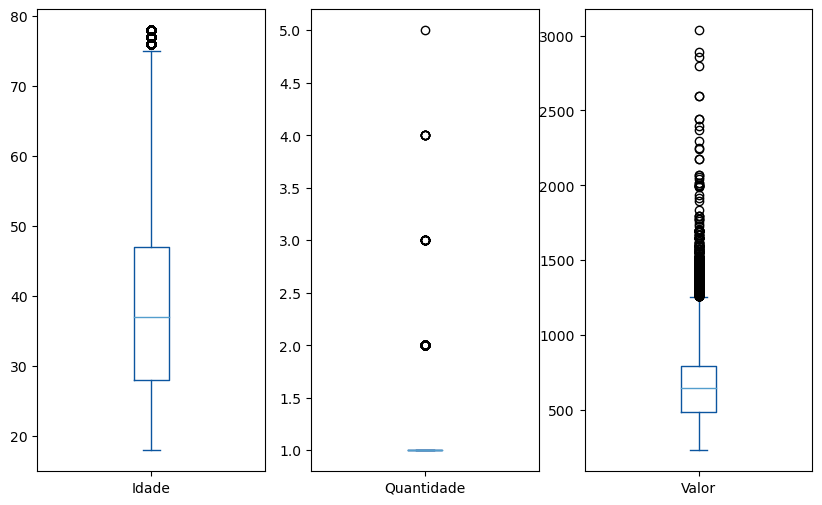

In [199]:
# Colunas específicas que você deseja incluir no resumo
colunas_especificas = ['Idade', 'Quantidade', 'Valor']

df_store_data[colunas_especificas].plot(kind='box', figsize=(10,6), subplots=True)

# Exibe os gráficos
plt.show()

## > Variável Idade

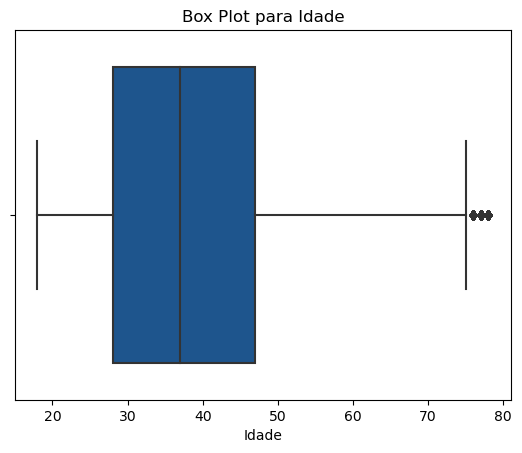

In [200]:
# Exibindo box plot para coluna específica (Age)
sns.boxplot(x=df_store_data['Idade'])
plt.title('Box Plot para Idade')
plt.show()

#### o que seria esses outliers ?

In [201]:
df_store_data[df['Idade']>=75]

,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,SKU,...,Tamanho,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B,Faixa Etária
8,408-2935263-2935550,2935263,Feminino,75,Mais Antigo,2022-12-04,Dec,Entregue,Amazon,JNE3474-KR-E-XL,...,XL,1,INR,385,BENGALURU,KARNATAKA,562149,IN,False,75+
10,404-2648970-9042715,2648970,Feminino,76,Mais Antigo,2022-12-04,Dec,Entregue,Amazon,JNE3795-KR-S,...,S,1,INR,517,THIRUVANANTHAPURAM,KERALA,695018,IN,False,75+
28,406-0947452-6044339,947452,Masculino,77,Mais Antigo,2022-12-04,Dec,Entregue,Flipkart,JNE3797-KR-XXL,...,XXL,1,INR,735,CHENNAI,TAMIL NADU,600103,IN,False,75+
58,407-7643005-7856329,7643005,Masculino,75,Mais Antigo,2022-12-04,Dec,Entregue,Flipkart,SET402-KR-NP-XXXL,...,3XL,1,INR,988,MUMBAI,MAHARASHTRA,400063,IN,False,75+
67,403-8213196-3804353,8213196,Masculino,75,Mais Antigo,2022-12-04,Dec,Entregue,Myntra,SET218-KR-NP-S,...,S,1,INR,667,BOKARO STEEL CITY,JHARKHAND,827001,IN,False,75+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30867,406-9291498-4721121,9291498,Feminino,75,Mais Antigo,2022-01-06,Jan,Entregue,Amazon,JNE3482-KR-M,...,M,1,INR,318,BENGALURU,KARNATAKA,560075,IN,False,75+
30892,405-1149218-8616316,1149218,Masculino,78,Mais Antigo,2022-01-06,Jan,Entregue,Myntra,SET295-KR-NP-XXL,...,XXL,1,INR,747,LUCKNOW,UTTAR PRADESH,226021,IN,False,75+
30896,406-9515575-5735567,9515575,Masculino,77,Mais Antigo,2022-01-06,Jan,Entregue,Myntra,J0346-SET-XL,...,XL,1,INR,474,NEW DELHI,DELHI,110002,IN,False,75+
30986,405-1233080-6535522,1233080,Feminino,77,Mais Antigo,2022-01-06,Jan,Entregue,Others,J0342-TP-M,...,M,1,INR,625,AHMADNAGAR,MAHARASHTRA,414001,IN,False,75+


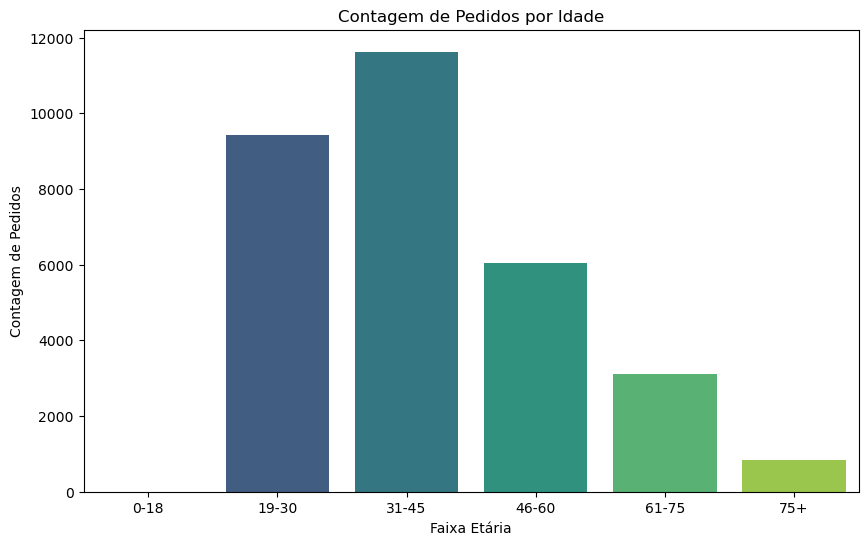

In [202]:
# Gráfico de barras para contagem de pedidos por idade
plt.figure(figsize=(10, 6))
sns.countplot(x='Faixa Etária', data=df_store_data, palette='viridis')
plt.title('Contagem de Pedidos por Idade')
plt.xlabel('Faixa Etária')
plt.ylabel('Contagem de Pedidos')
plt.show()

## > Variável Quantidade

In [262]:
# Calculando a assimetria usando Scipy
assimetria = skew(df_store_data['Quantidade'])

# Exibindo a assimetria
print(f'A assimetria dos dados é: {assimetria}')

A assimetria dos dados é: 19.44996051287185


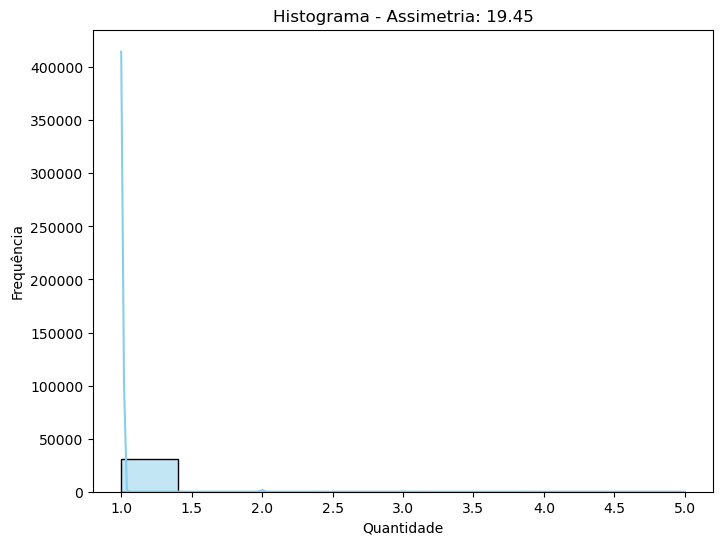

In [263]:
# Plotando o histograma
plt.figure(figsize=(8, 6))
sns.histplot(df_store_data['Quantidade'], bins=10, kde=True, color='skyblue')
plt.title(f'Histograma - Assimetria: {assimetria:.2f}')
plt.xlabel('Quantidade')
plt.ylabel('Frequência')
plt.show()

## > Variável Valor

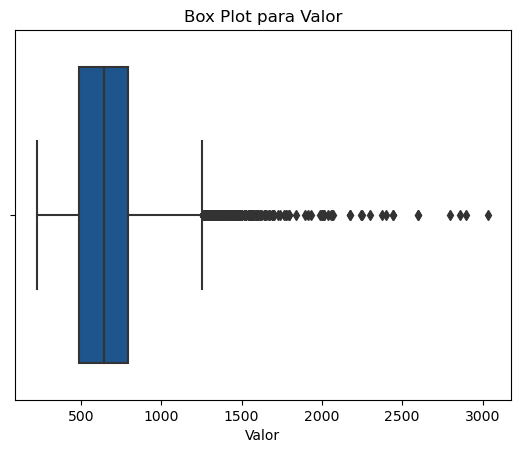

In [203]:
# Exibindo box plot para coluna específica (Valor)
sns.boxplot(x=df_store_data['Valor'])
plt.title('Box Plot para Valor')
plt.show()

In [260]:
# Calculando a assimetria usando Scipy
assimetria = skew(df_store_data['Valor'])

# Exibindo a assimetria
print(f'A assimetria dos dados é: {assimetria}')

A assimetria dos dados é: 1.0528531381395165


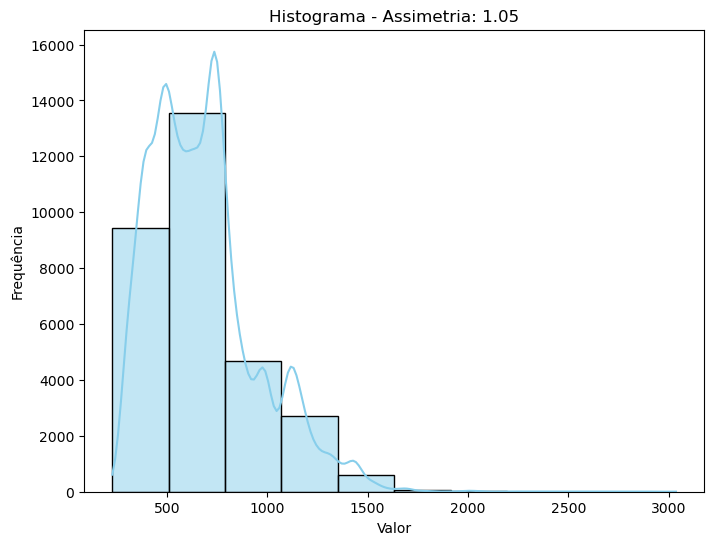

In [261]:
# Plotando o histograma
plt.figure(figsize=(8, 6))
sns.histplot(df_store_data['Valor'], bins=10, kde=True, color='skyblue')
plt.title(f'Histograma - Assimetria: {assimetria:.2f}')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

#### o que seria esses outliers ?

In [247]:
df_store_data[df_store_data['Valor']>=1500]


,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,SKU,...,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B,Faixa Etária,Mes_Numero
10655,402-4825408-3491550,4825408,Masculino,49,Adulto,2022-01-04,Jan,Entregue,Meesho,J0011-LCD-M,...,1,INR,1695,KOLKATA,WEST BENGAL,700075,IN,False,46-60,1
10723,403-0738182-8116332,738182,Feminino,24,Adolescente,2022-01-04,Jan,Entregue,Flipkart,SET278-KR-NP-XS,...,1,INR,1523,KOTTAYAM,KERALA,686004,IN,False,19-30,1
10689,405-8735551-6526736,8735551,Feminino,28,Adolescente,2022-01-04,Jan,Entregue,Flipkart,MEN5032-KR-XXL,...,2,INR,1574,SILIGURI,WEST BENGAL,734006,IN,False,19-30,1
10182,404-7590356-5834726,7590356,Feminino,59,Mais Antigo,2022-01-04,Jan,Entregue,Flipkart,SET269-KR-NP-S,...,2,INR,1648,Udupi,KARNATAKA,574122,IN,False,46-60,1
10355,403-7345571-5978754,7345571,Feminino,28,Adolescente,2022-01-04,Jan,Entregue,Amazon,J0285-SKD-M,...,1,INR,1523,KANNIYAKUMARI,TAMIL NADU,629171,IN,False,19-30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11339,171-2479334-9324300,2479334,Masculino,70,Mais Antigo,2022-12-05,Dec,Entregue,Nalli,J0228-SKD-XL,...,1,INR,1613,JODHPUR,RAJASTHAN,342001,IN,False,61-75,12
11328,406-7108075-6684347,7108075,Masculino,30,Adulto,2022-12-05,Dec,Entregue,Meesho,PSET043-KR-NP-5XL,...,1,INR,1629,HYDERABAD,TELANGANA,502032,IN,False,31-45,12
11295,404-6035777-0361962,6035777,Feminino,30,Adulto,2022-12-05,Dec,Entregue,Ajio,J0011-LCD-XL,...,1,INR,1695,HYDERABAD,TELANGANA,500050,IN,False,31-45,12
21687,404-2649447-3468332,2649447,Feminino,57,Mais Antigo,2022-12-06,Dec,Entregue,Amazon,J0280-SKD-M,...,1,INR,1556,BENGALURU,KARNATAKA,560068,IN,False,46-60,12


##  Verificando e salvando a base no excel para tirar Dúvidas!

In [34]:
# base_excel = df[df['Valor']>=1500]
# base_excel.to_excel('Verificar.xlsx')

## > vamos fazer uma Análise Descritiva para entender melhor  os dados

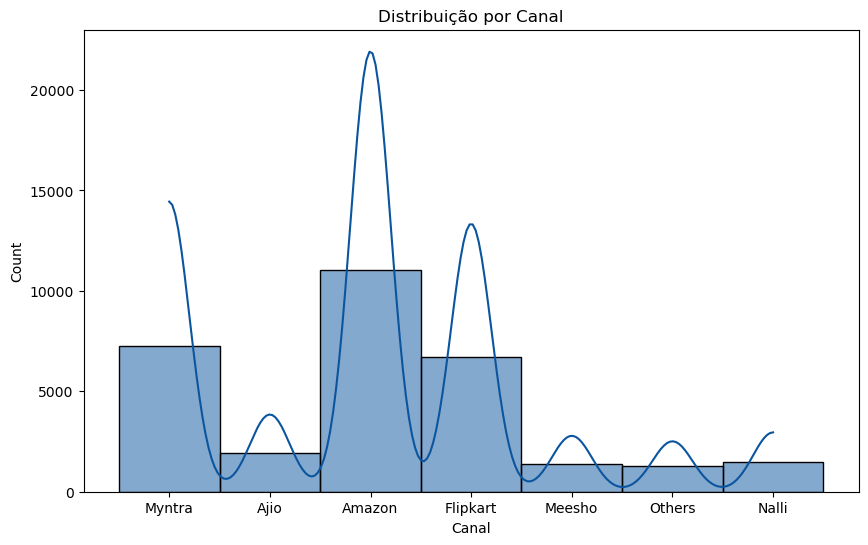

In [206]:


# Exemplo: Histograma da idade
plt.figure(figsize=(10, 6))
sns.histplot(df_store_data['Canal'], bins=20, kde=True)
plt.title('Distribuição por Canal')
plt.show()


In [207]:
#Contagem de Ocorrências (Frequência)

contagem_canal = df_store_data['Canal'].value_counts().to_frame('count')
contagem_canal



,count
Amazon,11016
Myntra,7254
Flipkart,6703
Ajio,1931
Nalli,1484
Meesho,1398
Others,1261


In [208]:
percentual_canal = df_store_data['Canal'].value_counts(normalize=True) * 100
percentual_canal


Amazon      35.481689
Myntra      23.364576
Flipkart    21.589848
Ajio         6.219603
Nalli        4.779850
Meesho       4.502851
Others       4.061584
Name: Canal, dtype: float64

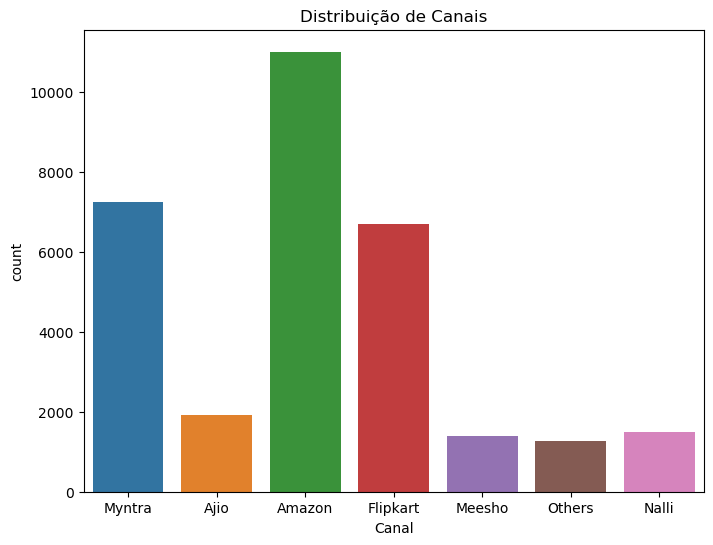

In [39]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Canal', data=df_store_data)
plt.title('Distribuição de Canais')
plt.show()

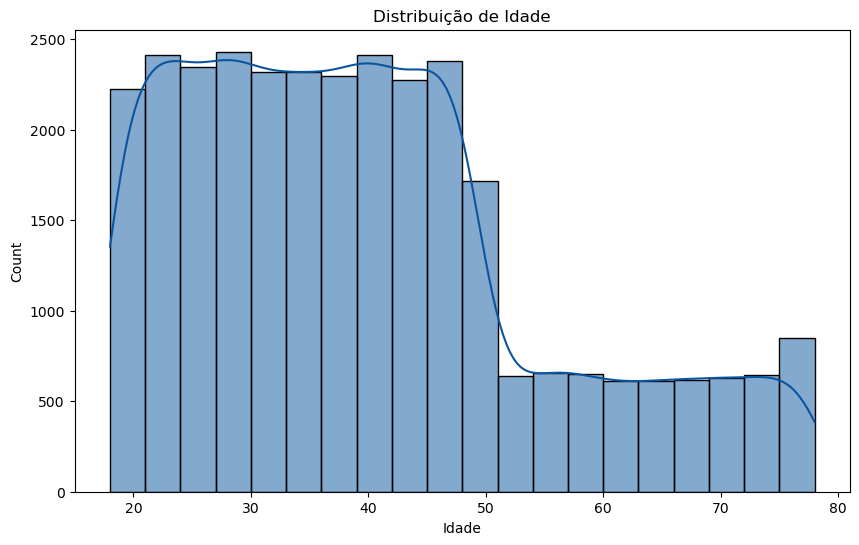

In [209]:


# Exemplo: Histograma da idade
plt.figure(figsize=(10, 6))
sns.histplot(df_store_data['Idade'], bins=20, kde=True)
plt.title('Distribuição de Idade')
plt.show()


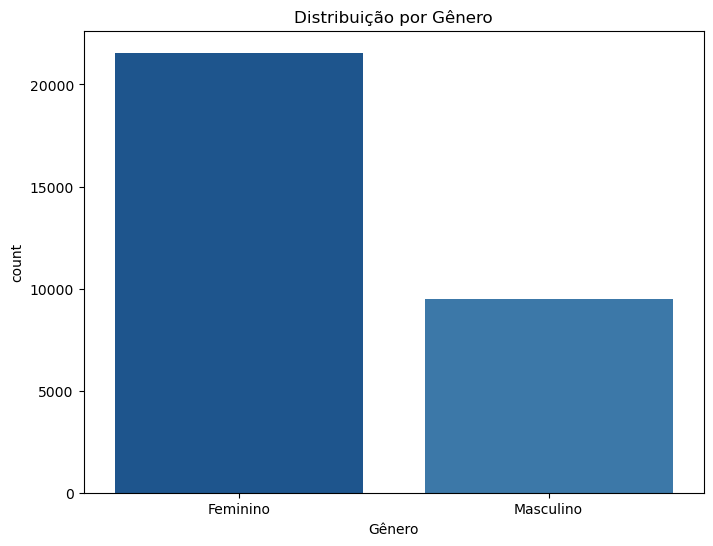

In [210]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Gênero', data=df_store_data)
plt.title('Distribuição por Gênero')
plt.show()

In [211]:

contagem_canal = df_store_data['Grupo Etário'].value_counts().to_frame('count')
contagem_canal


,count
Adulto,15543
Adolescente,9415
Mais Antigo,6089


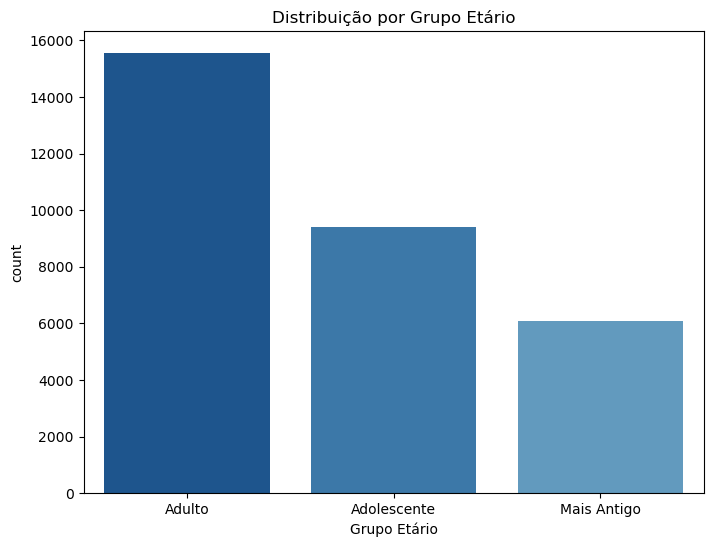

In [212]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Grupo Etário', data=df_store_data)
plt.title('Distribuição por Grupo Etário')
plt.show()

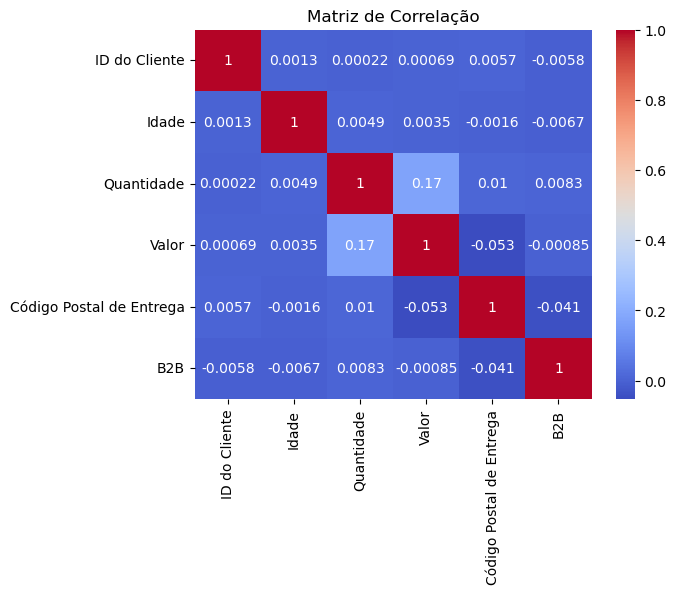

In [213]:
matriz_correlacao = df_store_data.corr()
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


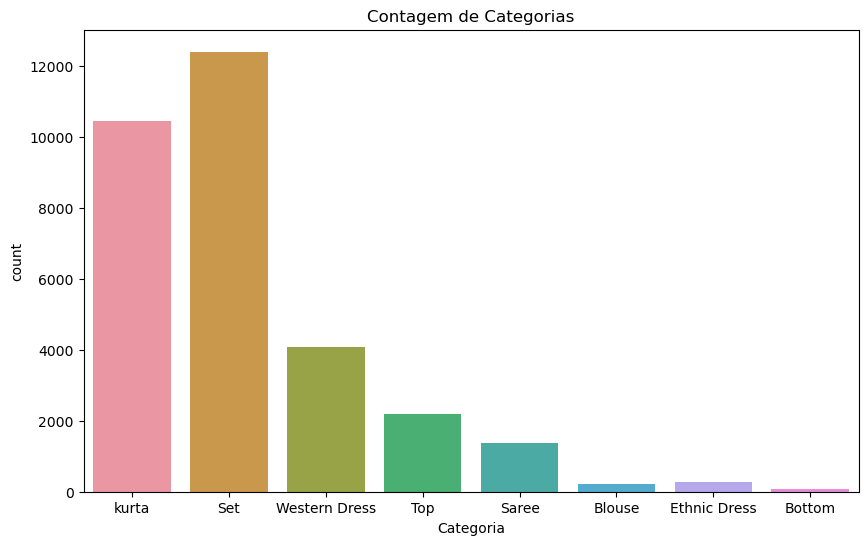

In [214]:
# Exemplo: Gráfico de barras para a categoria
plt.figure(figsize=(10, 6))
sns.countplot(x='Categoria', data=df_store_data)
plt.title('Contagem de Categorias')
plt.show()


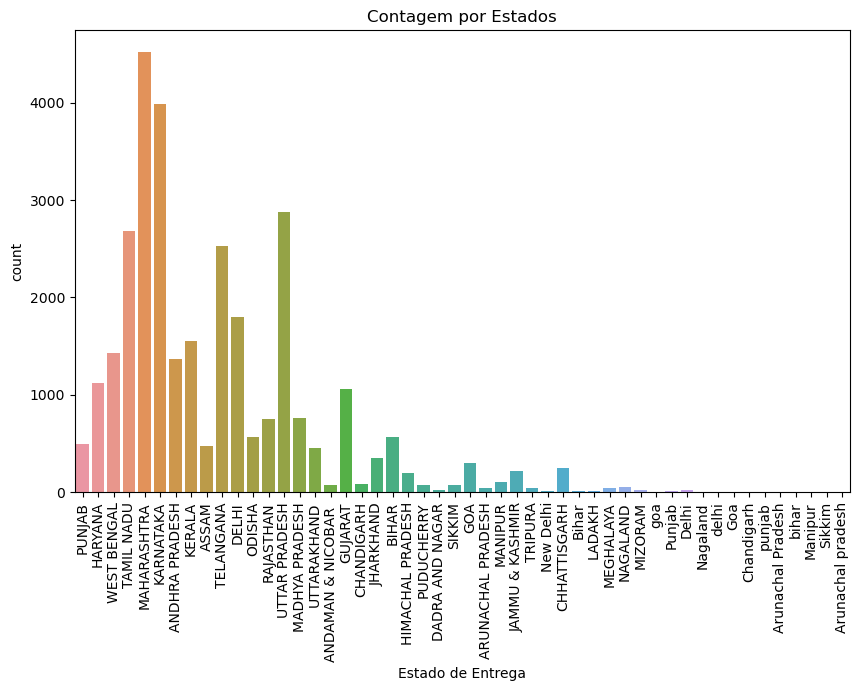

In [215]:
# Exemplo: Gráfico de barras para a categoria
plt.figure(figsize=(10, 6))
sns.countplot(x='Estado de Entrega', data=df_store_data)
plt.title('Contagem por Estados')

# Rótulos do eixo x na vertical
plt.xticks(rotation=90)


plt.show()


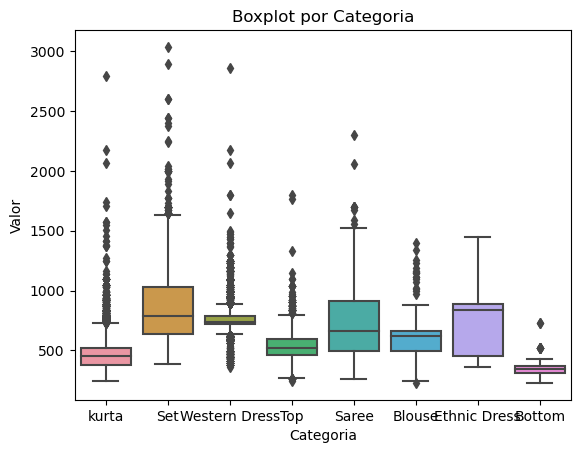

In [216]:
sns.boxplot(x='Categoria', y='Valor', data=df_store_data)
plt.title('Boxplot por Categoria')
plt.show()

In [69]:
# Defina a ordem desejada dos meses
ordem_meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Reordene o DataFrame agrupado de acordo com a ordem dos meses
df_agrupado = df_agrupado.reindex(ordem_meses)

# Imprima o resultado do agrupamento ordenado
print(df_agrupado)


Mês
Jan    1820601
Feb    1875932
Mar    1928066
Apr    1829263
May    1797822
Jun    1750966
Jul    1772300
Aug    1808505
Sep    1688871
Oct    1666662
Nov    1615356
Dec    1622033
Name: Valor, dtype: int64


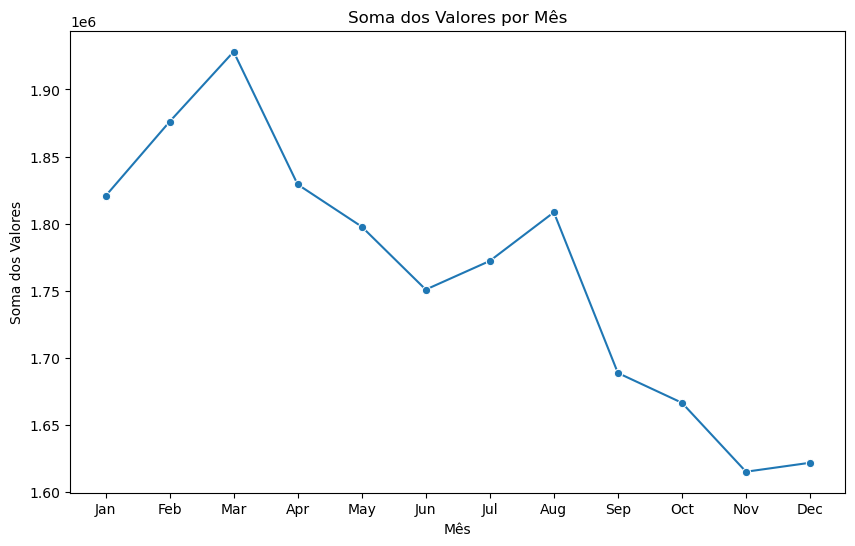

In [74]:


# Defina a ordem dos meses
ordem_meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Reordene o DataFrame agrupado
df_agrupado = df_agrupado.reindex(ordem_meses)

# Crie o gráfico de linha
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_agrupado.index, y=df_agrupado.values, marker='o')

# Adicione rótulos e título
plt.xlabel('Mês')
plt.ylabel('Soma dos Valores')
plt.title('Soma dos Valores por Mês')

# Exiba o gráfico
plt.show()


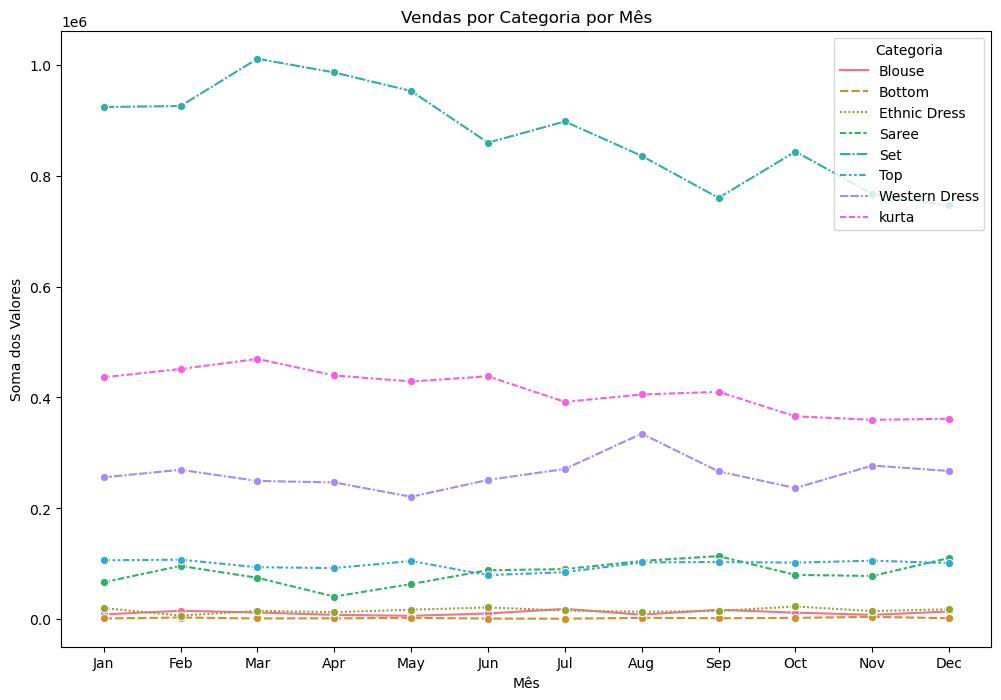

In [217]:


# Pivotando o DataFrame para ter as categorias como colunas
df_pivot = df_store_data.pivot_table(index='Mês', columns='Categoria', values='Valor', aggfunc='sum', fill_value=0)

# Reordenando o DataFrame
df_pivot = df_pivot.reindex(ordem_meses)

# Criando o gráfico de linha
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_pivot, marker='o')

# Adicionando rótulos e título
plt.xlabel('Mês')
plt.ylabel('Soma dos Valores')
plt.title('Vendas por Categoria por Mês')

# Exibindo o gráfico
plt.show()


In [218]:
# Ajuste os dados para o gráfico de pizza
tipo_categoria = df_store_data['Categoria'].value_counts().to_frame('count')
tipo_categoria

,count
Set,12391
kurta,10446
Western Dress,4066
Top,2193
Saree,1380
Ethnic Dress,264
Blouse,229
Bottom,78


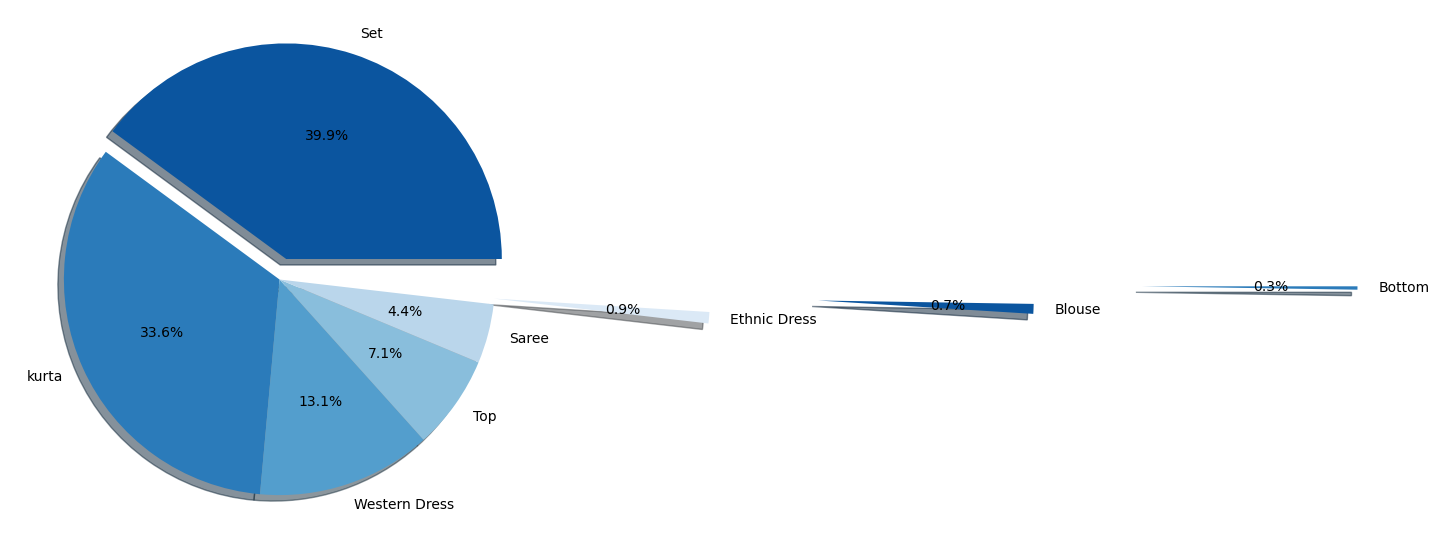

In [219]:
# Grafico de pizza da Categoria

sns.set_palette('Blues_r')
plt.figure(figsize=(7,7))
plt.pie(tipo_categoria['count'],labels= tipo_categoria.index, explode =(0.1,0,0,0,0,1,2.5,4),
       shadow=True,
       autopct='%1.1f%%')
plt.show()

In [243]:
df_store_data.head()

,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,SKU,...,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B,Faixa Etária,Mes_Numero
31046,408-4694875-8249153,4694875,Masculino,36,Adulto,2022-01-06,Jan,Entregue,Flipkart,J0341-DR-XXXL,...,1,INR,791,WARANGAL,TELANGANA,506001,IN,False,31-45,1
10655,402-4825408-3491550,4825408,Masculino,49,Adulto,2022-01-04,Jan,Entregue,Meesho,J0011-LCD-M,...,1,INR,1695,KOLKATA,WEST BENGAL,700075,IN,False,46-60,1
10656,402-4003610-3161169,4003610,Feminino,26,Adolescente,2022-01-04,Jan,Entregue,Myntra,JNE3476-KR-XL,...,1,INR,363,NEW DELHI,DELHI,110017,IN,False,19-30,1
10657,408-2409103-9856336,2409103,Feminino,23,Adolescente,2022-01-04,Jan,Entregue,Flipkart,J0349-SET-M,...,1,INR,791,HYDERABAD,TELANGANA,500032,IN,False,19-30,1
10658,402-9068892-1041116,9068892,Masculino,75,Mais Antigo,2022-01-04,Jan,Entregue,Ajio,SET253-KR-NP-L,...,1,INR,737,HYDERABAD,TELANGANA,500020,IN,False,75+,1


In [244]:
df_store_data.tail()
# print('Tempo de Processamento:', int(final - inicio), 'segundos')

,ID do Pedido,ID do Cliente,Gênero,Idade,Grupo Etário,Data,Mês,Status,Canal,SKU,...,Quantidade,Moeda,Valor,Cidade de Entrega,Estado de Entrega,Código Postal de Entrega,País de Entrega,B2B,Faixa Etária,Mes_Numero
10910,402-3747697-3263557,3747697,Feminino,46,Adulto,2022-12-05,Dec,Entregue,Amazon,SET398-KR-PP-XXXL,...,1,INR,1129,NEW DELHI,DELHI,110027,IN,False,46-60,12
10911,171-7605234-2616357,7605234,Feminino,18,Adolescente,2022-12-05,Dec,Entregue,Flipkart,J0118-TP-M,...,1,INR,529,JAMMU,JAMMU & KASHMIR,180004,IN,False,19-30,12
10912,408-4804006-2777930,4804006,Feminino,37,Adulto,2022-12-05,Dec,Entregue,Myntra,JNE3645-TP-N-M,...,1,INR,432,BENGALURU,KARNATAKA,560076,IN,False,31-45,12
10938,402-3766529-0479569,3766529,Masculino,52,Mais Antigo,2022-12-05,Dec,Devolvido,Flipkart,JNE3797-KR-XXXL,...,1,INR,715,pune,MAHARASHTRA,411048,IN,False,46-60,12
0,171-1029312-3038738,1029312,Feminino,44,Adulto,2022-12-04,Dec,Entregue,Myntra,JNE1233-BLUE-KR-031-XXL,...,1,INR,376,MOHALI,PUNJAB,140301,IN,False,31-45,12


## Salvando o Dataframe  e carregando os  dados tratados  para o s3 para camada Gold

In [246]:


# Configurações do AWS
AWS_ACCESS_KEY = "AKIA5UI6Q........"
AWS_SECRET_KEY = "XjaHyb8eUyFt+......"
AWS_REGION = "us-east-2"

# Configurações do Amazon S3
bucket_name = "datalakelojavrinda"
s3_folder_gold = "staging/Camada_Gold"
s3_file_name_gold = "Store_Data_Gold.csv"  # Nome desejado para o arquivo na camada Gold

# Configuração do cliente S3
s3 = boto3.client("s3", aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_KEY, region_name=AWS_REGION)

# DataFrame tratado (substitua isso pelo seu DataFrame)
df_store_tratado =df_store_data

# Especifica o caminho completo, incluindo o nome do arquivo desejado na camada Gold
local_file_path_gold = "C:/Users/ROBERTO/Store_Data_Gold.csv"

# Salva o DataFrame como um arquivo CSV
df_store_tratado.to_csv(local_file_path_gold, index=False)

# Upload do arquivo tratado para o Amazon S3 na camada Gold
s3.upload_file(local_file_path_gold, bucket_name, f"{s3_folder_gold}/{s3_file_name_gold}")

print(f"Upload bem-sucedido para o Amazon S3 na camada Gold: {s3_folder_gold}/{s3_file_name_gold}")


Upload bem-sucedido para o Amazon S3 na camada Gold: staging/Camada_Gold/Store_Data_Gold.csv


###  Resultado da Análise(Insights) 

#### > 1. Diferença de Gênero nas Compras:

 As mulheres apresentam uma probabilidade 65% maior de fazer compras em comparação aos homens.

#### > 2. Principais Estados em Vendas:
    
 Maharashtra, Karnataka e Uttar Pradesh destacam-se como os três principais estados em volume de vendas.

#### > 3. Contribuição por Faixa Etária:
    
 O grupo de idade adulta (30-49 anos) é o que mais contribui, representando uma contribuição de 50%.


#### >4. Principais Canais de Venda:

 Aprimorado: Os canais de venda Amazon, Flipkart e Myntra são os principais contribuintes, representando 80% do total de vendas.

###  Conclusão Final:

> Direcione campanhas de marketing para mulheres na faixa etária de 30 a 49 anos, residentes em Maharashtra, Karnataka e Uttar Pradesh, destacando anúncios, ofertas e cupons disponíveis nos canais de venda da Amazon, Flipkart e Myntra.

 # Fim